In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency
from datetime import datetime as datet
from google.colab import drive
drive.mount('/content/drive') #подключаем гугл коллаб

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Baseline

In [8]:
df_fi = pd.read_csv('/content/drive/My Drive/EkoNiva/fields_without_humus.csv', encoding='utf-8', sep=',', decimal='.')
#df_fi = df_fi.drop(columns=['Unnamed: 18'])
df_fi = df_fi.drop_duplicates(keep='first')

df_fi.head()

,field,region,land_type,fertility_score,season,crop,crop_predecessor,crop_yearold,area,hybrid,reproduction,seed_origin,technology,yield_plan,p2o5,k2o,humus,ph
0,22.47.01.001.01,Алтай,пашня,NaN,2023,Оз.пшеница мягкая,Пар; Яр.пшеница мягкая,NaN,306.22,Скипетр,ЭС,Покупные,минимальная,3.8,243.16,226.93,4.46,5.78
1,22.47.01.001.02,Алтай,пашня,NaN,2023,Пар,Пар; Яр.пшеница мягкая,NaN,63.16,NaN,NaN,NaN,минимальная,NaN,243.16,226.93,4.46,5.78
2,22.47.01.002.00,Алтай,пашня,4.0,2023,Пар,Яр.пшеница мягкая,NaN,485.79,NaN,NaN,NaN,NaN,NaN,219.78,204.60,3.85,5.72
3,22.47.01.003.00,Алтай,пашня,4.0,2023,Оз.пшеница мягкая,Пар,NaN,452.25,Скипетр,ЭС,Покупные,минимальная,3.8,205.15,192.28,6.49,5.94
4,22.47.01.004.00,Алтай,пашня,3.0,2023,Оз.пшеница мягкая,Пар,NaN,269.64,Скипетр,ЭС,Покупные,минимальная,3.8,183.26,162.69,6.16,5.94


In [9]:
df_fi.dtypes

,0
field,object
region,object
land_type,object
fertility_score,float64
season,int64
crop,object
crop_predecessor,object
crop_yearold,float64
area,float64
hybrid,object


In [10]:
df_fi['season'].value_counts()

,count
season,
2023,5142
2024,2994


In [11]:
df_fi.isna().sum()

,0
field,0
region,0
land_type,0
fertility_score,237
season,0
crop,0
crop_predecessor,13
crop_yearold,6351
area,0
hybrid,2962


In [12]:
def corr_cat(x, y): # функция для подсчета корреляции для 2х категориальных переменных
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ( (r-1)**2 / (n-1) )
    kcorr = k - ( (k-1)**2 / (n-1) )
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

'''
def coor_cat_num(numeric, categor): # функция для подсчета корреляции для категор/номинал
    df = df_f[[numeric, categor]].dropna()
    mezhgroup = vnutrigroup = 0
    meann = df[numeric].mean()
    for znach in set(df[categor].dropna()):
        data = pd.Series(df[df[categor] == znach][numeric]).dropna()
        vnutrigroup += sum([(elem - data.mean()) ** 2 for elem in data])
        mezhgroup += data.fillna(0).shape[0] * (pd.Series([data.mean()]).fillna(0)[0] - meann) ** 2
        print(znach)
    return (mezhgroup / (mezhgroup + vnutrigroup)) ** 0.5
    '''
def coor_cat_num(df, numeric, categor):
    mezhgroup = vnutrigroup = 0
    meann = df[numeric].mean()
    unique_categories = pd.Series(df[categor]).dropna().unique()
    for znach in unique_categories:
        data = df[df[categor] == znach][numeric].dropna()  # Фильтрация и удаление NaN для каждой категории
        if data.empty:
            continue  # Пропускаем категории без данных
        # Внутригрупповая дисперсия
        vnutrigroup += ((data - data.mean()) ** 2).sum()
        # Межгрупповая дисперсия
        mezhgroup += len(data) * (data.mean() - meann) ** 2
    return (mezhgroup / (mezhgroup + vnutrigroup)) ** 0.5

##Выведем корреляции неколичественны значений, где у нас наны

In [13]:
for cat in ['fertility_score', 'crop_predecessor', "hybrid", "reproduction", "seed_origin", "technology"]:
    print(cat + ":")
    for num in ['crop_yearold', 'area', 'yield_plan', 'p2o5', 'k2o', 'humus', 'ph']:
        if coor_cat_num(df_fi[[num, cat]].dropna(), num, cat) > 0.3: # чтобы коркоэф имел хотя бы умеренное влияние
            print(f'{num}: {round(coor_cat_num(df_fi[[num, cat]].dropna(), num, cat), 3)}', end='\t')
    for categ in ['region', 'land_type', 'season','crop']:
        if corr_cat(df_fi[cat], df_fi[categ]) > 0.3:
            print(f'{categ}: {round(corr_cat(df_fi[cat], df_fi[categ]), 3)}', end='\t')
    print()

fertility_score:
crop: 0.342	
crop_predecessor:
crop_yearold: 0.782	area: 0.378	ph: 0.4	region: 0.411	land_type: 0.944	crop: 0.53	
hybrid:
crop_yearold: 0.589	area: 0.366	yield_plan: 0.941	p2o5: 0.496	k2o: 0.393	humus: 0.473	ph: 0.536	region: 0.531	season: 0.497	crop: 0.635	
reproduction:
crop_yearold: 0.356	

<ipython-input-12-b41f90eb2754>:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


yield_plan: 0.413	crop: 0.429	
seed_origin:


<ipython-input-12-b41f90eb2754>:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))
<ipython-input-12-b41f90eb2754>:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


crop: 0.632	
technology:
region: 0.499	crop: 0.385	


<ipython-input-12-b41f90eb2754>:10: RuntimeWarning: invalid value encountered in scalar divide
  return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))


### С очень большой вероятностью мы правильно подставим данные в crop_predecessor по land_type

In [14]:
def fill_with_mode(group):
    mode_val = group.mode()
    return mode_val[0] if not mode_val.empty else np.nan

# Заполнение NaN в колонке crop_predecessor на основе land_type
df_fi['crop_predecessor'] = df_fi.groupby('land_type')['crop_predecessor'].transform(fill_with_mode)

In [15]:
df_fi['crop_predecessor'].isna().sum()

0

Не осталось нанов -- все прошло хорошо

###Создадим функцию для замены NaN

In [16]:
def repl_nan(col, dt_cols):
    global df_fi
    most_common = df_fi.groupby(dt_cols)[col].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else None).rename("most_common")
    df_fi = df_fi.join(most_common, on=dt_cols)
    df_fi[col] = df_fi[col].fillna(df_fi["most_common"])
    df_fi.drop(columns="most_common", inplace=True)  # Удаляем временный столбец, если нужно

###Изменим гибрид

In [17]:
hybr_prot = df_fi['yield_plan'].apply(lambda x: 0.2 if x < df_fi['yield_plan'].quantile(0.2)
                                      else 0.4 if x < df_fi['yield_plan'].quantile(0.4)
                                      else 0.6 if x < df_fi['yield_plan'].quantile(0.6)
                                      else 0.8 if x < df_fi['yield_plan'].quantile(0.8)
                                      else 1) # видим, что их корреляция с гибридом равна 0.95, так что классифицируем для подстановки через функцию

In [18]:
df_fi['hybr_prot'] = hybr_prot.copy()
corr_cat(df_fi['hybr_prot'], df_fi['hybrid'])

0.662908591703863

In [19]:
repl_nan('hybrid', ['crop', 'crop_yearold', 'hybr_prot'])
repl_nan('hybrid', ['crop', 'hybr_prot'])
repl_nan('hybrid', ['crop', 'crop_yearold'])
repl_nan('hybrid', ['hybr_prot'])

In [20]:
df_fi['hybrid'].isna().sum()

0

In [21]:
df_fi.drop(columns='hybr_prot', inplace=True)

###Изменим technology

In [22]:
repl_nan('technology', ['crop', 'region'])
# оставшиеся корреляции < 0.5, так что норм не заменим, дропаем
df_fi.dropna(subset='technology', inplace=True)

In [23]:
df_fi['technology'].isna().sum()

0

###Изменим seed_origin

In [24]:
repl_nan('seed_origin', ['crop'])
df_fi.dropna(subset='seed_origin', inplace=True) # дальше нечего подставлять, больше не корр

In [25]:
df_fi['seed_origin'].isna().sum()

0

###Изменим fertility_score (по функции Ината)

In [26]:
# Группируем данные и рассчитываем среднее по 'fertility_score' и округляем до целого
fertility_score_mod = df_fi.groupby(['region'])['fertility_score'].agg(lambda x: np.round(x.mean()))
# Заполняем пропуски в 'fertility_score_mod'
df_fi['fertility_score'] = df_fi['fertility_score'].fillna(
    df_fi.apply(lambda x: fertility_score_mod.get((x['region'])), axis=1)
)
# проверим на наличие nan после заполнения, вдруг ошибка какая была
print(df_fi['fertility_score'].isna().sum())

0


###Изменим yield_plan

In [27]:
df_fi['yield_plan'] = df_fi['yield_plan'].fillna(
    df_fi.groupby('hybrid')['yield_plan'].median()
)
repl_nan('yield_plan', ['crop_yearold', 'area'])
repl_nan('yield_plan', ['crop_yearold'])
repl_nan('yield_plan', ['area'])
df_fi.dropna(subset='yield_plan', inplace=True)

In [28]:
df_fi.isna().sum()

,0
field,0
region,0
land_type,0
fertility_score,0
season,0
crop,0
crop_predecessor,0
crop_yearold,5167
area,0
hybrid,0


###Изменим humus

In [29]:
# Группируем данные и рассчитываем среднее по 'humus'
hum_mean = df_fi.groupby(['region'])['humus'].mean()
# Заполняем пропуски в 'humus'
df_f = df_fi.copy() # для поиска корреляций без лишних медианных значений
df_fi['humus'] = df_fi['humus'].fillna(
    df_fi.apply(lambda x: hum_mean.get((x['region'])), axis=1)
)
# проверим на наличие nan после заполнения, вдруг ошибка какая была
df_fi.isna().sum()

,0
field,0
region,0
land_type,0
fertility_score,0
season,0
crop,0
crop_predecessor,0
crop_yearold,5167
area,0
hybrid,0


###Изменим crop_yearold

In [30]:
df_fi['crop_yearold'] = df_fi['crop_yearold'].fillna(0)

###Изменим reproduction

In [35]:
repl_nan('reproduction', ['crop', 'yield_plan'])
repl_nan('reproduction', ['crop'])
df_fi.dropna(subset='reproduction', inplace=True)

In [41]:
df_fi.isna().sum()

,0
field,0
region,0
land_type,0
fertility_score,0
season,0
crop,0
crop_predecessor,0
crop_yearold,0
area,0
hybrid,0


In [62]:
df_fi['yield_plan_full'] = df_fi['yield_plan'] * df_fi['area']

In [70]:
df_fi.to_csv('/content/drive/My Drive/EkoNiva/processing_fields.csv')

In [71]:
df_fi.shape

(6829, 19)

In [63]:
corr_matrix = pd.DataFrame(index=df_fi.columns, columns=df_fi.columns)
for i in range(corr_matrix.shape[0]):
    for j in range(corr_matrix.shape[0]):
        fir, sec = df_fi.columns[i], df_fi.columns[j]
        print(fir, sec)
        if fir == sec:
            corr_matrix.iat[i, j] = 1
            continue
        if df_fi.dtypes[fir] == object:
            if df_fi.dtypes[sec] == object:
                corr_matrix.iat[i, j] = corr_cat(df_fi[fir], df_fi[sec])
            else:
                corr_matrix.iat[i, j] = coor_cat_num(df_fi, sec, fir)
        else:
            if df_fi.dtypes[sec] == object:
                corr_matrix.iat[i, j] = coor_cat_num(df_fi, fir, sec)
            else: corr_matrix.iat[i, j] = df_fi.corr(numeric_only=1)[fir][sec]

field field
field region
field land_type
Chi-squared statistic is 0; variables are independent.
field fertility_score
field season
field crop
field crop_predecessor
Chi-squared statistic is 0; variables are independent.
field crop_yearold
field area
field hybrid
field reproduction
field seed_origin
field technology
field yield_plan
field p2o5
field k2o
field humus
field ph
field yield_plan_full
region field
region region
region land_type
Chi-squared statistic is 0; variables are independent.
region fertility_score
region season
region crop
region crop_predecessor
Chi-squared statistic is 0; variables are independent.
region crop_yearold
region area
region hybrid
region reproduction
region seed_origin
region technology
region yield_plan
region p2o5
region k2o
region humus
region ph
region yield_plan_full
land_type field
Chi-squared statistic is 0; variables are independent.
land_type region
Chi-squared statistic is 0; variables are independent.
land_type land_type
land_type fertility_sc

In [51]:
corr_cat(df_fi['crop_predecessor'], df_fi['field'])

Chi-squared statistic is 0; variables are independent.


0

In [64]:
corr_matrix = corr_matrix.fillna(0).astype(float)

<ipython-input-64-3b68a1596288>:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  corr_matrix = corr_matrix.fillna(0).astype(float)


In [65]:
corr_matrix

,field,region,land_type,fertility_score,season,crop,crop_predecessor,crop_yearold,area,hybrid,reproduction,seed_origin,technology,yield_plan,p2o5,k2o,humus,ph,yield_plan_full
field,1.000000,0.572332,0.0,0.998580,0.547828,0.239628,0.0,0.921588,0.998284,0.239505,0.286017,0.357962,0.371818,0.901067,0.732474,0.907802,0.661133,0.808168,0.971808
region,0.572332,1.000000,0.0,0.279506,0.145860,0.349305,0.0,0.219345,0.366815,0.491820,0.204129,0.289617,0.499691,0.223633,0.301126,0.420983,0.099878,0.606134,0.191733
land_type,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
fertility_score,0.998580,0.279506,0.0,1.000000,-0.054718,0.398729,0.0,-0.087759,0.095124,0.440846,0.167015,0.057294,0.135386,0.059069,0.127284,0.182354,0.002027,0.238055,0.089043
season,0.547828,0.145860,0.0,-0.054718,1.000000,0.282238,0.0,-0.005397,-0.271511,0.496033,0.090775,0.051420,0.052885,-0.016646,-0.724418,-0.129555,0.692121,-0.382508,-0.158716
crop,0.239628,0.349305,0.0,0.398729,0.282238,1.000000,0.0,0.890632,0.262168,0.679338,0.466584,0.727716,0.359398,0.975711,0.260596,0.232132,0.230749,0.376978,0.696744
crop_predecessor,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
crop_yearold,0.921588,0.219345,0.0,-0.087759,-0.005397,0.890632,0.0,1.000000,-0.054637,0.820877,0.541136,0.098633,0.140481,-0.101469,-0.003638,-0.086671,-0.014903,-0.030045,-0.094105
area,0.998284,0.366815,0.0,0.095124,-0.271511,0.262168,0.0,-0.054637,1.000000,0.340631,0.119307,0.050028,0.105369,-0.005336,0.275571,0.119283,-0.176343,0.087501,0.504532
hybrid,0.239505,0.491820,0.0,0.440846,0.496033,0.679338,0.0,0.820877,0.340631,1.000000,0.554549,0.612411,0.469315,0.948139,0.453374,0.355231,0.394121,0.493925,0.672972


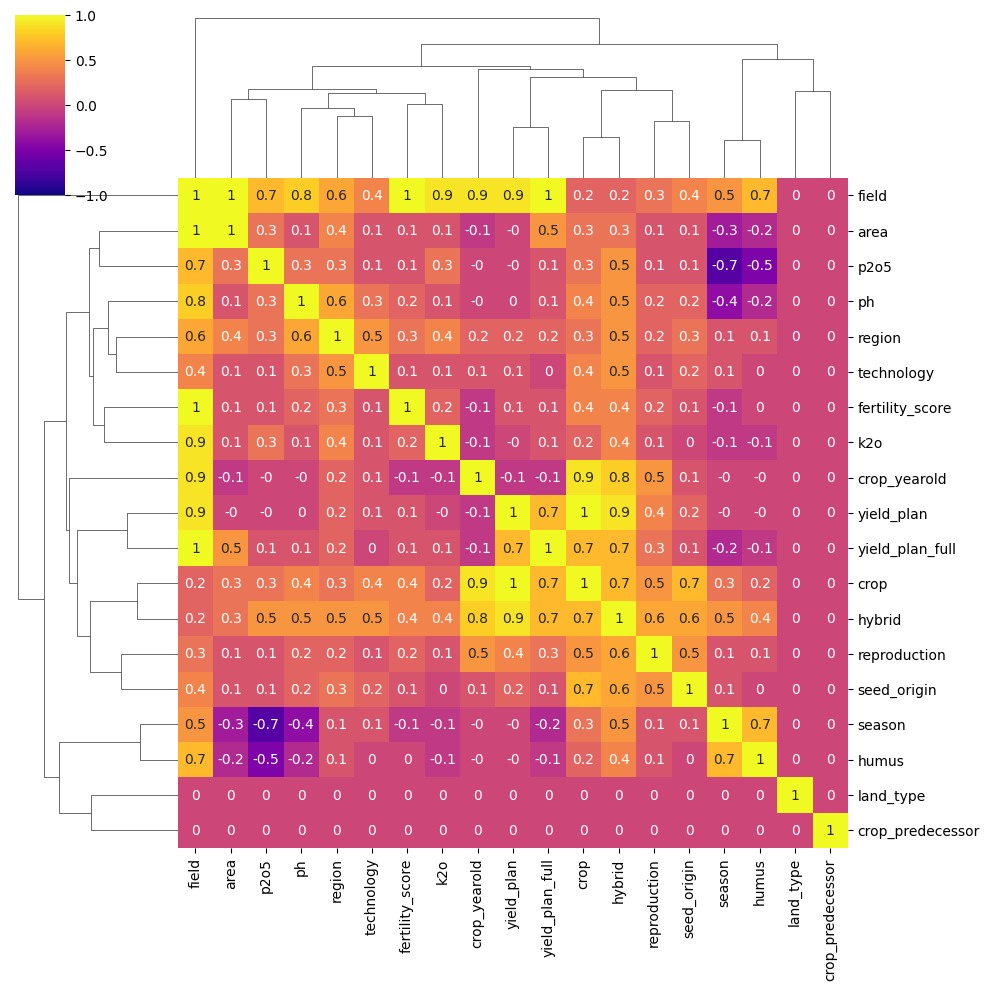

In [66]:
sns.clustermap(corr_matrix.round(1), annot=True, cmap='plasma', vmin=-1)

In [68]:
corr_matrix.to_csv('/content/drive/My Drive/EkoNiva/corr_matrix.csv', index=0)

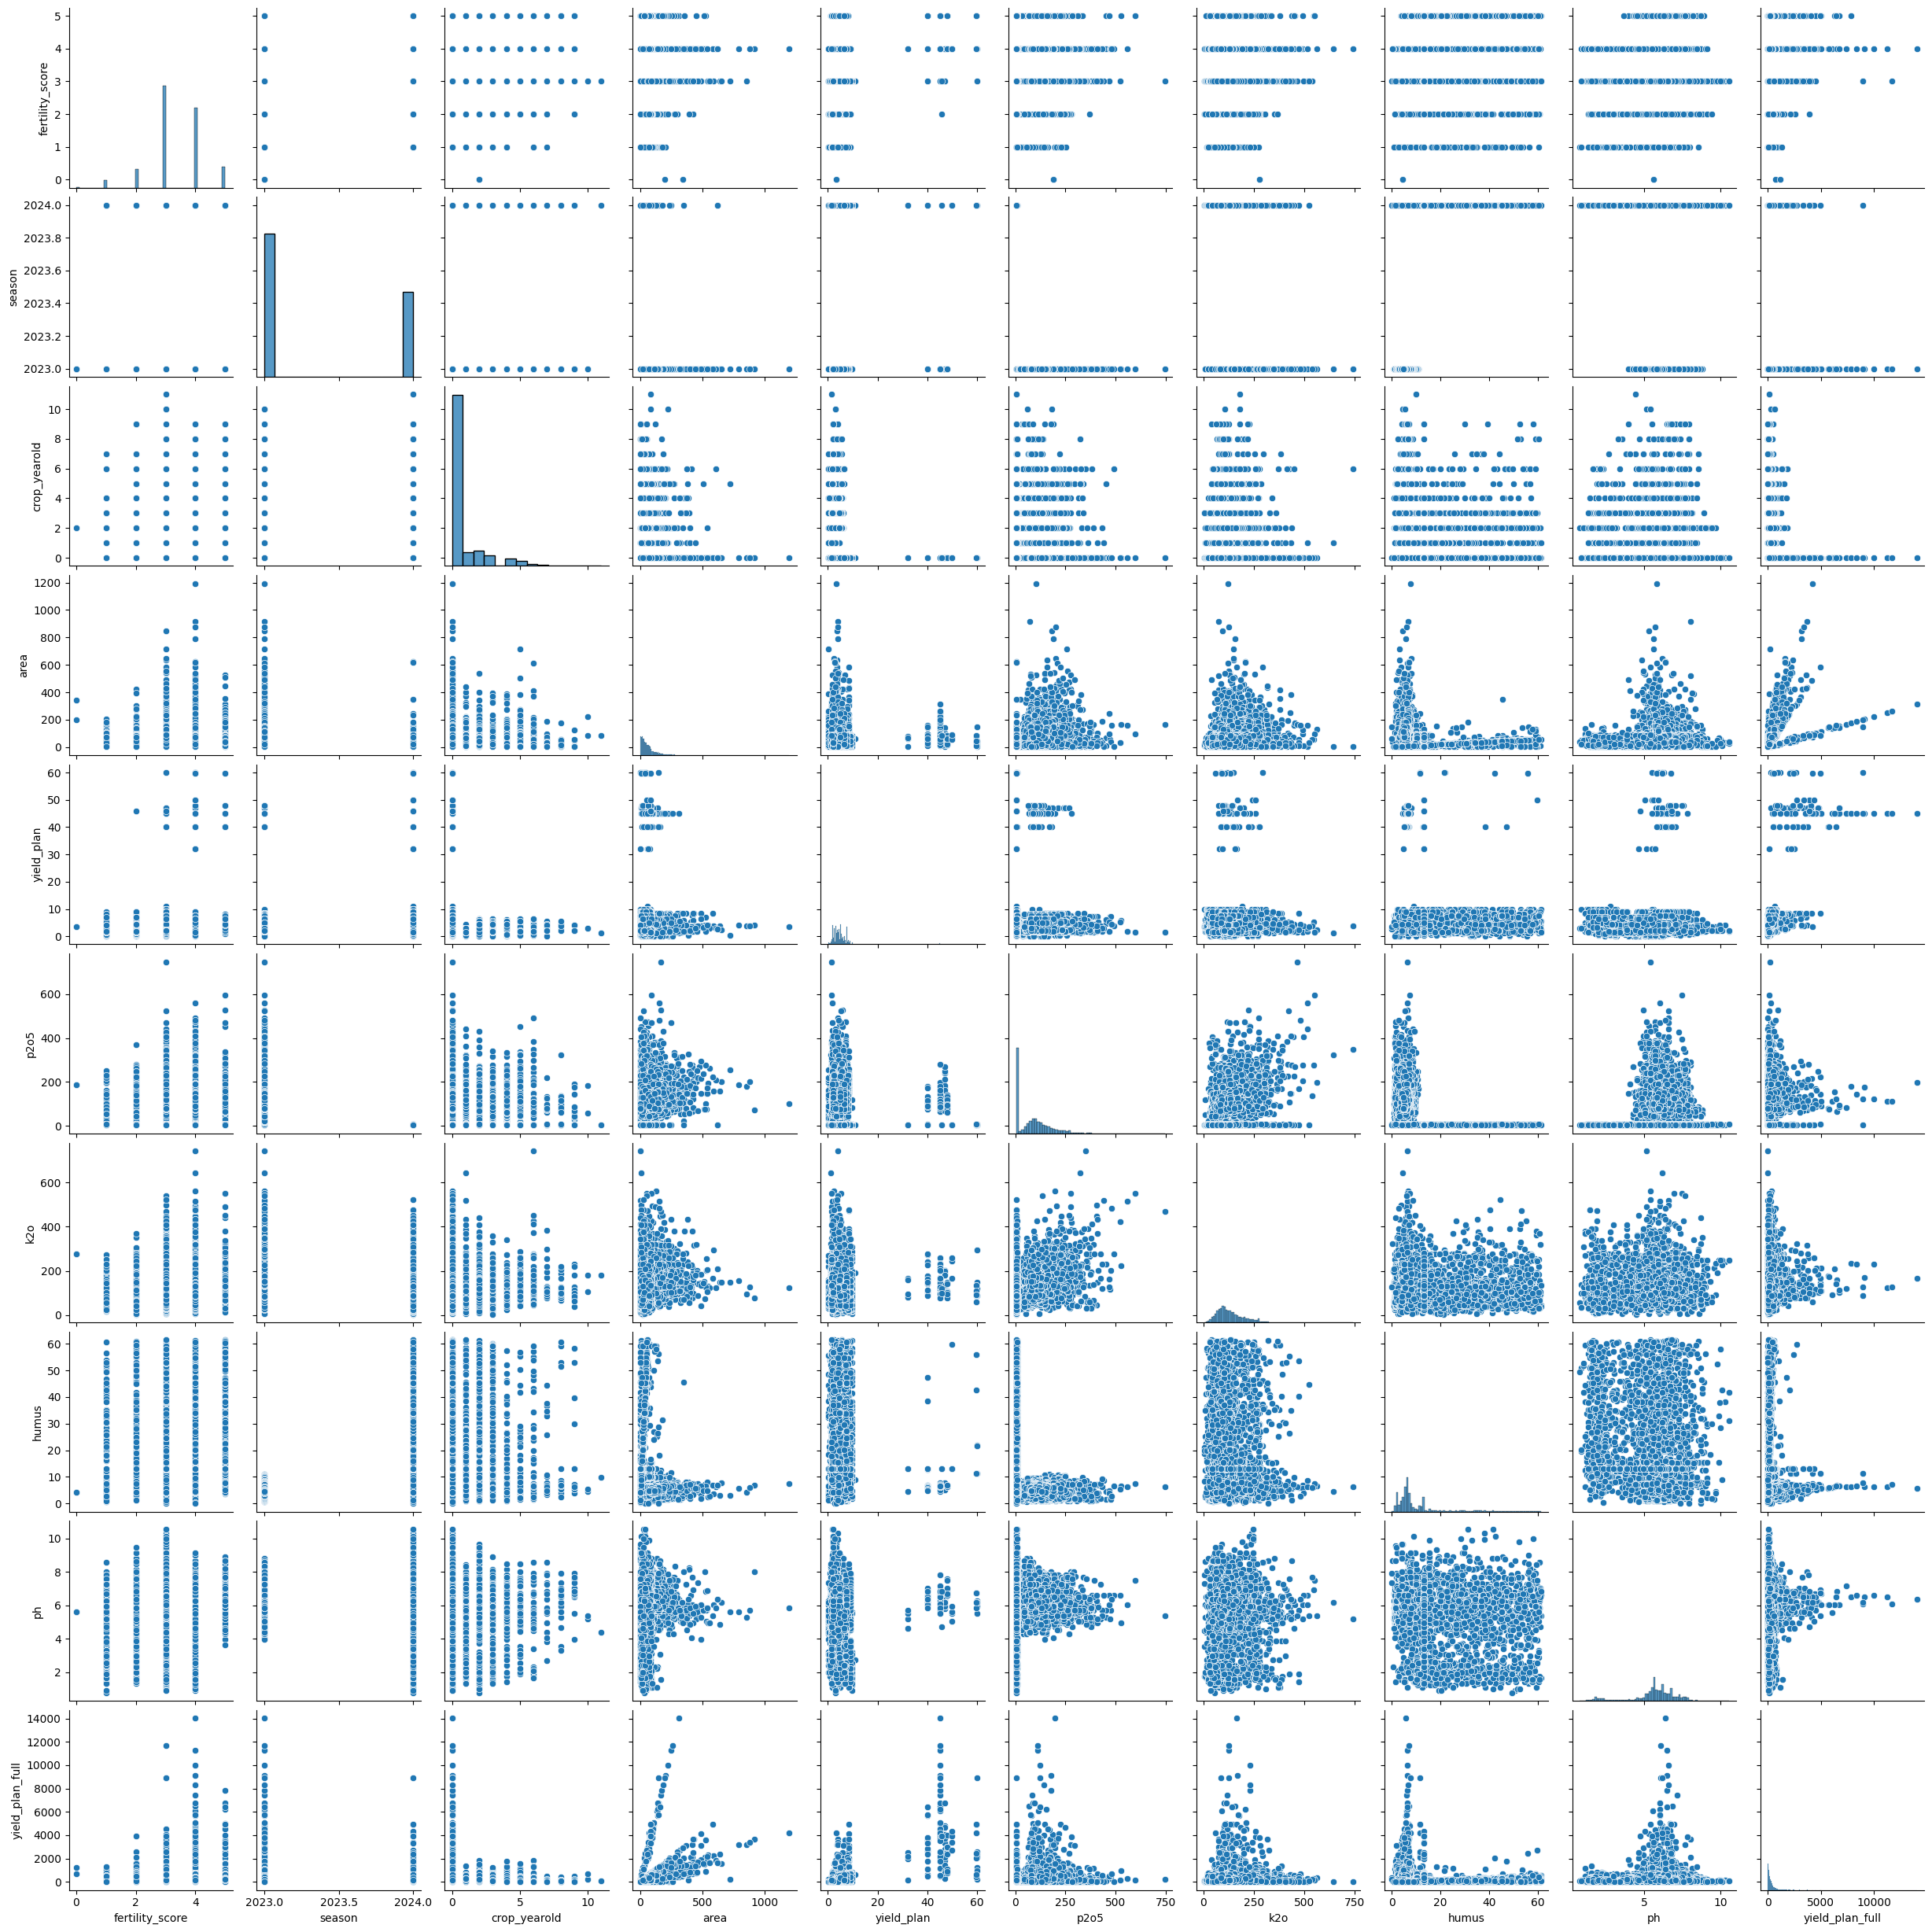

In [67]:
sns.pairplot(df_fi)
plt.show()